In [23]:
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')

In [240]:
df = pd.read_csv('LSTM-Multivariate_pollution.csv') 
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [26]:
df.isnull().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [27]:
x_train = df[:24865]
y_train = x_train['pollution']
x_test = df[24865:31898]
y_test = x_test['pollution']
print(y_test)

24865    212.0
24866    206.0
24867    199.0
24868    210.0
24869    194.0
         ...  
31893    123.0
31894    141.0
31895    121.0
31896    110.0
31897    116.0
Name: pollution, Length: 7033, dtype: float64


In [28]:
train_norm = x_train['pollution']

#converted into array as all the methods available are for arrays and not lists
train_norm_arr = np.asarray(train_norm)
train_norm = np.reshape(train_norm_arr, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)
for i in range(5):
    print(train_norm[i])

[0.12977867]
[0.14889336]
[0.15995976]
[0.18209256]
[0.138833]


In [29]:
count = 0
for i in range(len(train_norm)):
    if train_norm[i] == 0:
        count = count +1
print('Number of null values in train_norm = ', count)

Number of null values in train_norm =  1712


In [30]:
train_norm = train_norm[train_norm!=0]

In [31]:
test_norm = x_test['pollution']
test_norm_arr = np.asarray(test_norm)
test_norm = np.reshape(test_norm_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)
for i in range(5):
    print(test_norm[i])

[0.23927765]
[0.23250564]
[0.22460497]
[0.23702032]
[0.21896163]


In [32]:
count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1 
print('Number of null values in test_norm = ', count)

Number of null values in test_norm =  199


In [33]:
test_norm = test_norm[test_norm != 0]

In [34]:
print(train_norm.shape)
print(test_norm.shape)

(23153,)
(6834,)


In [35]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

In [36]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))

In [37]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

[0.23927765 0.23250564 0.22460497] 0.237020316027088
[0.23250564 0.22460497 0.23702032] 0.21896162528216703
[0.22460497 0.23702032 0.21896163] 0.22121896162528215
[0.23702032 0.21896163 0.22121896] 0.21896162528216703
[0.21896163 0.22121896 0.21896163] 0.21896162528216703


In [38]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

#sgd = optimizers.SGD(lr=0.001, decay=1e-5, momentum=1.0, nesterov=False)
# sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True) #good
keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True,
    weight_decay=1e-5)

#keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [39]:
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=15, verbose = 1)

Epoch 1/15
724/724 [==============================] - 1s 943us/step - loss: 0.0019 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 1.4639e-04
Epoch 2/15
724/724 [==============================] - 1s 919us/step - loss: 8.7088e-04 - accuracy: 0.0000e+00 - val_loss: 9.7578e-04 - val_accuracy: 1.4639e-04
Epoch 3/15
724/724 [==============================] - 1s 836us/step - loss: 7.1146e-04 - accuracy: 0.0000e+00 - val_loss: 9.0157e-04 - val_accuracy: 1.4639e-04
Epoch 4/15
724/724 [==============================] - 1s 837us/step - loss: 6.7690e-04 - accuracy: 0.0000e+00 - val_loss: 8.5359e-04 - val_accuracy: 1.4639e-04
Epoch 5/15
724/724 [==============================] - 1s 838us/step - loss: 6.4749e-04 - accuracy: 0.0000e+00 - val_loss: 8.2671e-04 - val_accuracy: 1.4639e-04
Epoch 6/15
724/724 [==============================] - 1s 842us/step - loss: 6.2600e-04 - accuracy: 0.0000e+00 - val_loss: 8.2255e-04 - val_accuracy: 1.4639e-04
Epoch 7/15
724/724 [============================

In [40]:
yhat = model.predict(X_split_test)
for i in range(5):
    print(yhat[i])

214/214 [==============================] - 0s 373us/step
[0.22067729]
[0.23846483]
[0.21353996]
[0.22004256]
[0.21779665]


In [41]:
pred=[]
for i in yhat:
  pred.append(i[0])
result=pd.DataFrame({'test':y_split_test,'pred':pred})
result


,test,pred
0,0.237020,0.220677
1,0.218962,0.238465
2,0.221219,0.213540
3,0.218962,0.220043
4,0.218962,0.217797
...,...,...
6826,0.138826,0.135498
6827,0.159142,0.142879
6828,0.136569,0.165083
6829,0.124153,0.135005


In [42]:
mse = mean_squared_error(y_split_test, yhat)
from sklearn.metrics import r2_score
print('MSE: %.5f' % mse)
print('R2 Score',r2_score(y_split_test,yhat))

MSE: 0.00080
R2 Score 0.9375422345209261


In [49]:
print(type(y_split_test),type(yhat))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [48]:
y_testReshaped = y_split_test.reshape(-1)
y_test_plt = pd.Series(y_testReshaped)

In [50]:
yhatReshaped = yhat.reshape(-1)
yhatplt = pd.Series(yhatReshaped)

<Axes: >

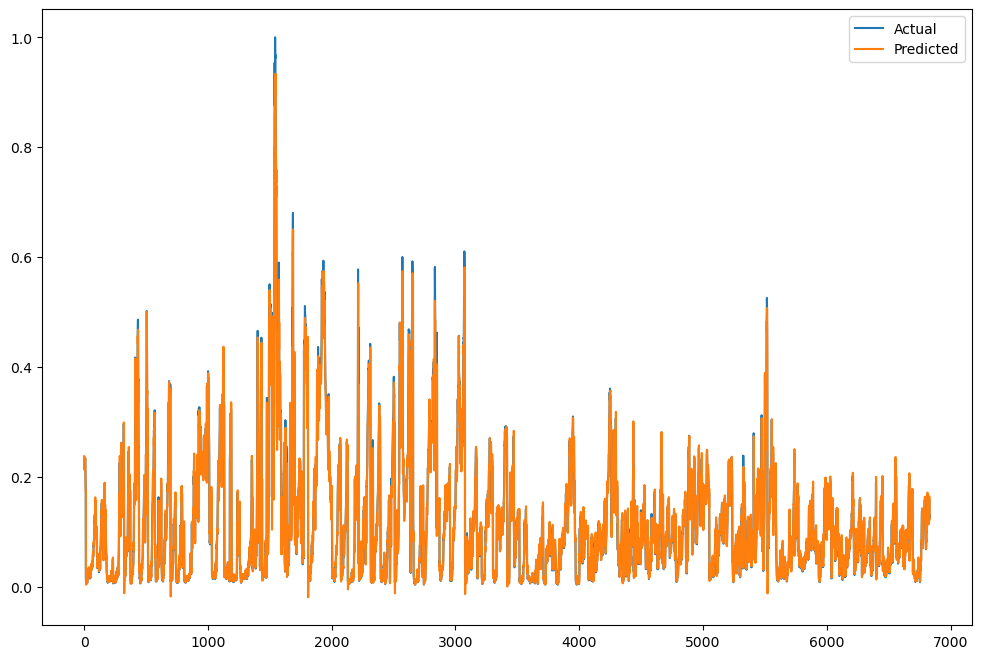

In [54]:
y_test_plt.plot(legend=True,label='Actual',figsize=(12,8))
yhatplt.plot(legend=True,label='Predicted')

<hr style='height:3px'>

# Applying SARIMAX(statsmodels) for Time Series Forecasting and comparing RNN and SARIMAX
## Date: 10 oct, 2024

In [241]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [242]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [243]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
df.set_index('date')

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [244]:
df = df.drop(columns=['wnd_dir', 'wnd_spd', 'snow'])

In [245]:
ndf = df.groupby('date').mean().reset_index()
ndf.head()

,date,pollution,dew,temp,press,rain
0,2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,0.0
1,2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,0.0
2,2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,0.0
3,2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,0.0
4,2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,0.0


In [246]:
print(len(ndf))

1825


In [247]:
ndf['date'] = pd.to_datetime(ndf['date'])
ndf.set_index('date')

,pollution,dew,temp,press,rain
date,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,0.0
...,...,...,...,...,...
2014-12-27,238.666667,-9.666667,-1.791667,1027.833333,0.0
2014-12-28,197.375000,-10.791667,1.583333,1019.958333,0.0
2014-12-29,159.000000,-12.333333,0.750000,1013.750000,0.0


<Axes: >

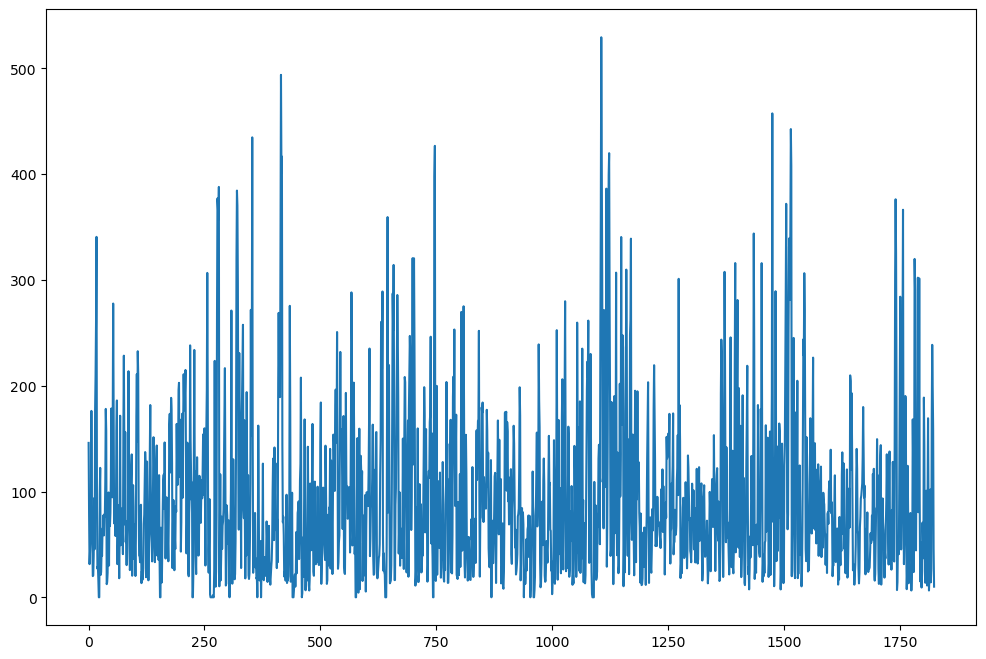

In [248]:
ndf['pollution'].plot(figsize=(12,8))

In [249]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','# lags used','# observations']
    out=pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})'] = val

    print(out.to_string())
    if result[1]<=0.05:
        print('Data is stationary')
    else:
        print('Data is non-stationary')

In [250]:
print(adf_test(ndf['pollution']))
print(adf_test(ndf['dew']))

ADF test statistics      -19.494692
p-value                    0.000000
# lags used                2.000000
# observations          1822.000000
critical value (1%)       -3.433944
critical value (5%)       -2.863128
critical value (10%)      -2.567615
Data is stationary
None
ADF test statistics       -2.252853
p-value                    0.187625
# lags used               11.000000
# observations          1813.000000
critical value (1%)       -3.433962
critical value (5%)       -2.863136
critical value (10%)      -2.567619
Data is non-stationary
None


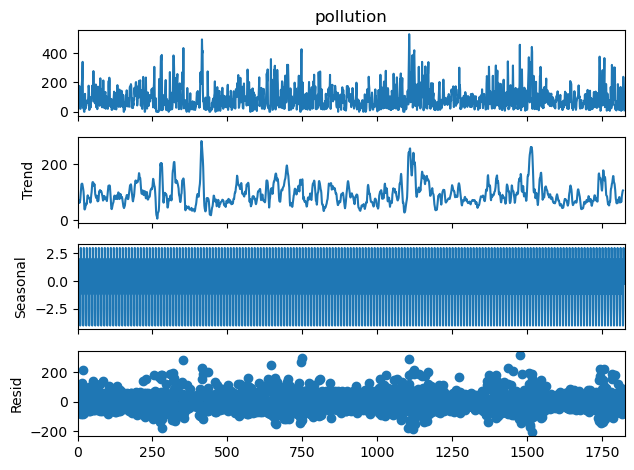

In [251]:
result = seasonal_decompose(ndf['pollution'],period=10)
result.plot();

In [256]:
auto_arima(ndf['pollution'],trace=True,seasonal=True,stationary=True,exog=[ndf['dew'],ndf['temp'],ndf['rain']],m=7).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=20294.064, Time=2.26 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=21052.771, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=20344.063, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=20377.287, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=22707.405, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=20298.204, Time=0.52 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=20298.205, Time=0.54 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=20295.433, Time=3.71 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=20294.491, Time=4.50 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=20296.208, Time=0.26 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=20299.854, Time=1.25 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=20299.822, Time=1.45 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=20293.323, Time=4.86 sec
 ARIMA(1,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(2,0,1)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1825
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood              -10137.550
Date:                                Thu, 10 Oct 2024   AIC                          20291.100
Time:                                        19:05:10   BIC                          20335.175
Sample:                                             0   HQIC                         20307.359
                                               - 1825                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     46.9199     10.407      4.508      0.000      26.522      67.317
ar.L1          0.3857      0.029     13.348      0.000       0.329       0.442
ma.L1          0.2863      0.033      8.715      0.000       0.222       0.351
ar.S.L7        0.8670      0.160      5.407      0.000       0.553       1.181
ar.S.L14      -0.6807      0.170     -4.006      0.000      -1.014      -0.348
ma.S.L7       -0.8901      0.149     -5.969      0.000      -1.182      -0.598
ma.S.L14       0.7333      0.157      4.680      0.000       0.426       1.040
sigma2      3920.1565    101.357     38.677      0.000    3721.501    4118.812
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               419.74
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.69
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [257]:
ndf.set_index('date',inplace=True)

In [258]:
train= ndf[:1795]
test = ndf[1795:]

In [259]:
test.head()

,pollution,dew,temp,press,rain
date,,,,,
2014-12-02,51.791667,-19.500000,-5.000000,1027.833333,0.0
2014-12-03,25.375000,-22.250000,-2.791667,1026.625000,0.0
2014-12-04,9.208333,-22.416667,-2.000000,1027.375000,0.0
2014-12-05,35.541667,-20.250000,-2.750000,1027.208333,0.0
2014-12-06,70.541667,-16.541667,-1.958333,1026.291667,0.0


In [266]:
ndf.index.freq='D'
train.head()
print(len(train['pollution']))
print(len(train['dew']))
print(len(train['rain']))
print(len(train['temp']))

1795
1795
1795
1795


In [327]:
arimaModel = SARIMAX(train['pollution'],exog=train['dew'],order=(1,1,2),seasonal_order=(2, 0, [1,2], 7)).fit()

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33524D+00    |proj g|=  3.99756D-02

At iterate    5    f=  5.33312D+00    |proj g|=  1.32014D-02

At iterate   10    f=  5.33261D+00    |proj g|=  1.81453D-03

At iterate   15    f=  5.33233D+00    |proj g|=  8.99643D-03

At iterate   20    f=  5.33226D+00    |proj g|=  1.60481D-03

At iterate   25    f=  5.33216D+00    |proj g|=  2.52793D-03

At iterate   30    f=  5.33148D+00    |proj g|=  3.29833D-03

At iterate   35    f=  5.33139D+00    |proj g|=  2.21761D-03

At iterate   40    f=  5.33114D+00    |proj g|=  2.29894D-04

At iterate   45    f=  5.33114D+00    |proj g|=  7.79208D-04

At iterate   50    f=  5.33092D+00    |proj g|=  6.69792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [328]:
start=len(train)
end=start+len(test)-1

In [329]:
predictions = arimaModel.predict(start,end,exog=test['dew'],typ='levels').rename('SARIMA Predictions')

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='date'>

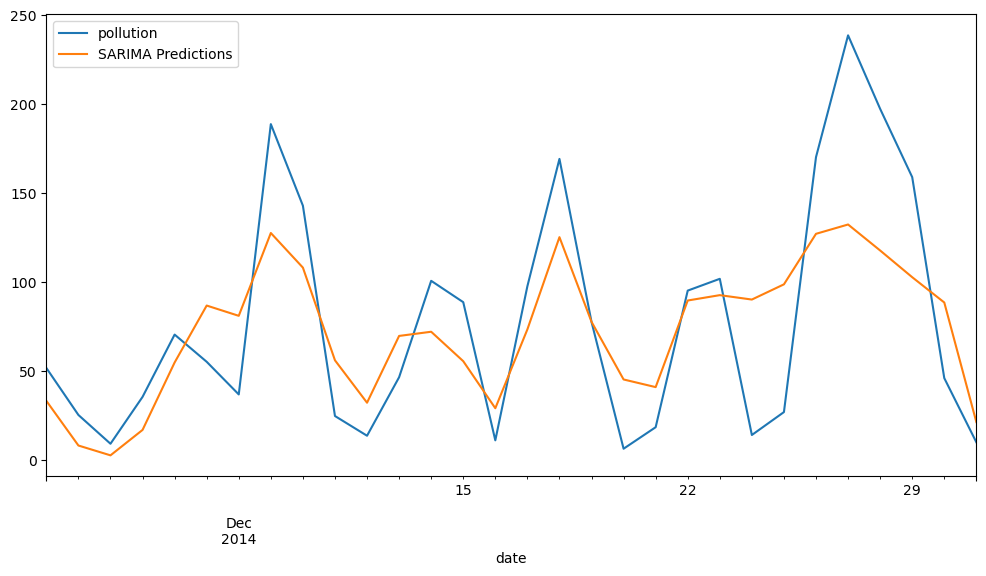

In [330]:
test['pollution'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)